# Classification

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Features shape: (70000, 784)
Digit label: 5


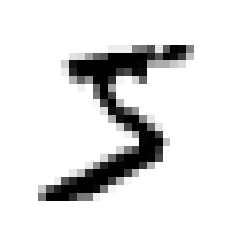

In [2]:
mnist = fetch_openml("mnist_784", version=1)
print(
    mnist.keys() # type: ignore
)

X, y = mnist["data"], mnist["target"] # type: ignore
y = y.astype(np.uint8)
print(f"Features shape: {X.shape}")

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28, 28)

print(f"Digit label: {y.iloc[0]}")
plt.imshow(
    some_digit_image,
    cmap=mpl.cm.binary, # type: ignore
    interpolation="nearest"
)
plt.axis("off")
plt.show()

The MNIST dataset is actually already split into a training set (the first 60,000 images)
and a test set (the last 10,000 images)  
The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some dig its). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

In [3]:
X_train, X_test, y_train, y_test = X.iloc[:60_000], X.iloc[60_000:], y.iloc[:60_000], y.iloc[60_000:]

## Training a Binary Classiier
Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5

In [4]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Performance Measures

### Confusion Matrix

In [5]:
# returns, for each element in the input, the prediction that was obtained
# for that element when it was in the test set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### Precision and Recall

In [6]:
print(f"Precision = {precision_score(y_train_5, y_train_pred)}")
print(f"Recall = {recall_score(y_train_5, y_train_pred)}")
print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}")

Precision = 0.8370879772350012
Recall = 0.6511713705958311
F1 Score: 0.7325171197343846


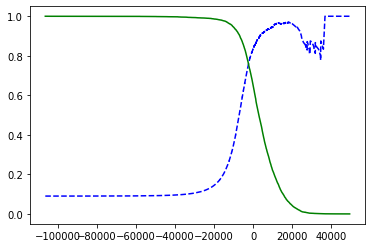

In [7]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

y_train_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_train_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [8]:
# Get the lowest threshold that gives you at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = y_train_scores >= threshold_90_precision

print(f"Precision = {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall = {recall_score(y_train_5, y_train_pred_90)}")
print(f"F1 Score: {f1_score(y_train_5, y_train_pred_90)}")


Precision = 0.9000345901072293
Recall = 0.4799852425751706
F1 Score: 0.626082771896054


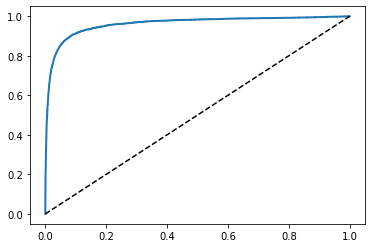

AUC: 0.9604938554008616


In [9]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal

fprs, tprs, thresholds = roc_curve(y_train_5, y_train_scores)
# The dotted line represents the ROC curve of a purely random classifier.
# A good classifier stays as far away from that line as possible (toward the top-left corner)
plot_roc_curve(fprs, tprs)
plt.show()
print(f"AUC: {roc_auc_score(y_train_5, y_train_scores)}")

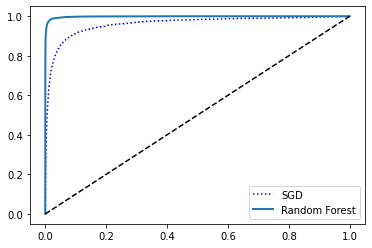

AUC: 0.998402186461512


In [10]:
forest_clf = RandomForestClassifier(random_state=42)
# Predict_proba() method returns an array containing a row per instance and a column per class,
# each containing the probability that the given instance belongs to the given class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method="predict_proba")
y_scores_forest = y_probas_forest[:,1] # Score = Probability of the positive class
fpr_forests, tpr_forests, thresholds = roc_curve(y_train_5, y_scores_forest)

plt.plot(fprs, tprs, "b:", label="SGD")
plot_roc_curve(fpr_forests, tpr_forests, "Random Forest")
plt.legend(loc="lower right")
plt.show()
print(f"AUC: {roc_auc_score(y_train_5, y_scores_forest)}")

### Multiclass Classification

In [11]:
sgd_clf.fit(X_train, y_train)
# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
# classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO)
print(f"Digit 5 prediction: {sgd_clf.predict([some_digit])}")

some_digit_scores = sgd_clf.decision_function([some_digit])
print(f"Digit 5 scores: {some_digit_scores}")

print(f"Classes: {sgd_clf.classes_}") # type: ignore

Digit 5 prediction: [3]
Digit 5 scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
Classes: [0 1 2 3 4 5 6 7 8 9]


/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [14]:
# Enforce one vs one classification
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(f"Digit 5 prediction: {ovo_clf.predict([some_digit])}")
print(f"Number of estimators: {len(ovo_clf.estimators_)}") # type: ignore

Digit 5 prediction: [5]
Number of estimators: 45


/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


In [23]:
scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print(f"Cross-Validation Scores: {scores}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"Cross-Validation Scores after scaling: {scores}")

Cross-Validation Scores: [0.87365 0.85835 0.8689 ]
Cross-Validation Scores after scaling: [0.8983 0.891  0.9018]


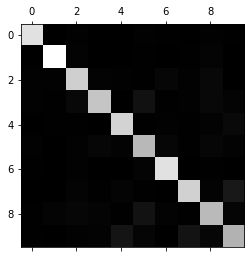

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray) # type: ignore
plt.show()

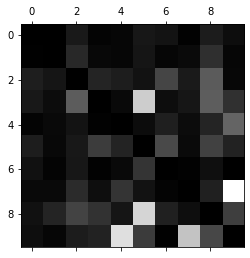

In [28]:
row_sums = conf_mx.sum(axis=1)
norm_conf_mx = conf_mx / row_sums
# Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel Classiication

In [36]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(f"Digit 5 prediction: {knn_clf.predict([some_digit])}")

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# This assumes that all labels are equally important
knn_f1_score = f1_score(y_multilabel, y_train_knn_pred, average="macro")
print(f"F1 Score: {knn_f1_score}")

/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Digit 5 prediction: [[False  True]]
F1 Score: 0.976410265560605


### Multioutput Classiication

/home/luiky/.pyenv/versions/3.9.11/envs/handson_ml_3911/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


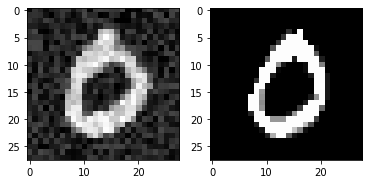

In [48]:
noise = np.random.randint(0, 100, X_train.shape)
X_train_mod = X_train + noise
y_train_mod = X_train

noise = np.random.randint(0, 100, X_test.shape)
X_test_mod = X_test + noise
y_test_mod = X_test

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[3]])
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(X_test_mod.iloc[3].values.reshape((28, 28)), cmap=plt.cm.gray) # type: ignore
plt.subplot(1,2,2)
plt.imshow(clean_digit.reshape((28, 28)), cmap=plt.cm.gray) # type: ignore
plt.show()

In [12]:
"""
The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions
"""

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

########## Implementing cross-validation ##########

skfolds = StratifiedKFold(
    n_splits=3,
    random_state=42,
    shuffle=True,
)

for train_indexes, test_indexes in skfolds.split(X_train, y_train_5):
    clone_clf: SGDClassifier = clone(sgd_clf) # type: ignore
    X_train_fold = X_train.iloc[train_indexes]
    y_train_fold = y_train_5.iloc[train_indexes]
    X_test_fold = X_train.iloc[test_indexes]
    y_test_fold = y_train_5.iloc[test_indexes]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))


0.9669
0.91625
0.96785
